In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def load_data():
    train_dataset = h5py.File('/content/drive/MyDrive/datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/MyDrive/datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


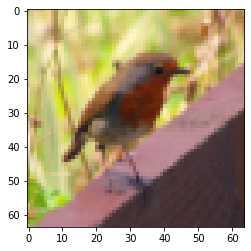

In [ ]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [ ]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.


### 3.2 - L-layer deep neural network


<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (32,32,3) image which is flattened to a vector of size (3720,1).
- The corresponding vector: $[x_0,x_1,...,x_{3719}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

In [ ]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [ ]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache


In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [ ]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [ ]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cross_entropy_cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cross_entropy_cost = np.squeeze(cross_entropy_cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cross_entropy_cost.shape == ())
    
    return cross_entropy_cost

In [ ]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(AL, Y, parameters, lambd, L):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    
    cross_entropy_cost = compute_cost(AL, Y) # This gives you the cross-entropy part of the cost
    
    ### START CODE HERE ### (approx. 1 line)
    for l in range(1,L):
         L2_regularization_cost = lambd * (np.sum(np.square(parameters["W"+str(l)]))) 
                                           
    L2_regularization_cost /= (2 * m)
    ### END CODER HERE ###
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [ ]:
def linear_backward(dZ, cache,lambd):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T) + ((lambd*W)/m)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db



In [ ]:
def linear_activation_backward(dA, cache,lambd,activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd)
    
    return dA_prev, dW, db

In [ ]:
def L_model_backward(AL, Y, caches, lambd):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    #Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,lambd, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache,lambd, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network
    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [ ]:
### CONSTANTS ###
layers_dims = [12288, 7, 5, 1] #  4-layer model

In [ ]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate,lambd, num_iterations = 1500, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    m = Y.shape[1]
    np.random.seed(1)
    costs = []                         # keep track of cost
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches =  L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost_with_regularization(AL, Y,parameters,lambd,len(layers_dims))
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches,lambd)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1, m),dtype=int)
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: %s" % str(np.sum(p == y)/float(m)))
        
    return p

lambda:  1.2  learning rate:  0.005  - 
Cost after iteration 0: 0.695773
Cost after iteration 100: 0.618347
Cost after iteration 200: 0.577515
Cost after iteration 300: 0.537475
Cost after iteration 400: 0.497752
Cost after iteration 500: 0.461386
Cost after iteration 600: 0.428976
Cost after iteration 700: 0.399351
Cost after iteration 800: 0.361491
Cost after iteration 900: 0.331003


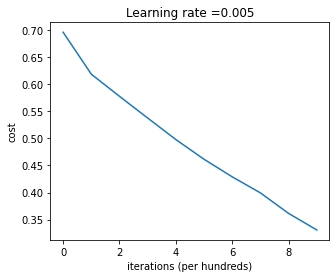

Accuracy: 0.9665071770334929
Accuracy: 0.76
lambda:  1.2  learning rate:  0.01  - 
Cost after iteration 0: 0.695773
Cost after iteration 100: 0.582813
Cost after iteration 200: 0.524934
Cost after iteration 300: 0.483552
Cost after iteration 400: 0.439504
Cost after iteration 500: 0.373160
Cost after iteration 600: 0.376962
Cost after iteration 700: 0.264977
Cost after iteration 800: 0.235879
Cost after iteration 900: 0.176973


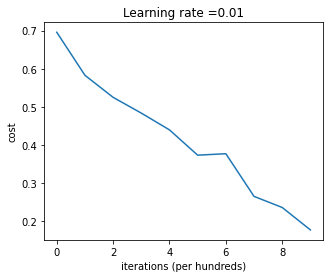

Accuracy: 0.9808612440191388
Accuracy: 0.64
lambda:  1.2  learning rate:  0.015  - 
Cost after iteration 0: 0.695773
Cost after iteration 100: 0.574775
Cost after iteration 200: 0.524008
Cost after iteration 300: 0.412077
Cost after iteration 400: 0.390270
Cost after iteration 500: 0.326045
Cost after iteration 600: 0.321068
Cost after iteration 700: 0.205436
Cost after iteration 800: 0.201231
Cost after iteration 900: 0.145738


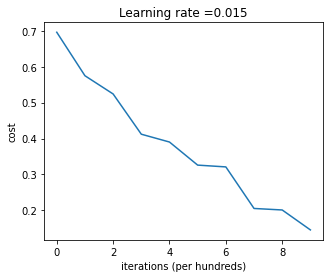

Accuracy: 0.9952153110047847
Accuracy: 0.68
lambda:  1.2  learning rate:  0.02  - 
Cost after iteration 0: 0.695773
Cost after iteration 100: 0.566724
Cost after iteration 200: 0.484309
Cost after iteration 300: 0.425523
Cost after iteration 400: 0.333016
Cost after iteration 500: 0.317226
Cost after iteration 600: 0.253730
Cost after iteration 700: 0.215565
Cost after iteration 800: 0.201317
Cost after iteration 900: 0.165052


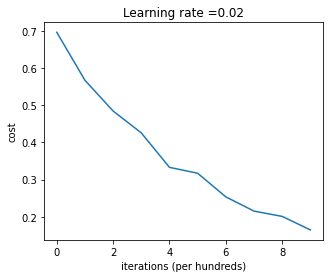

Accuracy: 0.8899521531100478
Accuracy: 0.76
lambda:  1.4  learning rate:  0.005  - 
Cost after iteration 0: 0.696145
Cost after iteration 100: 0.618853
Cost after iteration 200: 0.578321
Cost after iteration 300: 0.538223
Cost after iteration 400: 0.499494
Cost after iteration 500: 0.471309
Cost after iteration 600: 0.433166
Cost after iteration 700: 0.404582
Cost after iteration 800: 0.365299
Cost after iteration 900: 0.349168


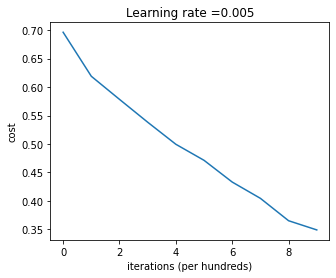

Accuracy: 0.9760765550239234
Accuracy: 0.7
lambda:  1.4  learning rate:  0.01  - 
Cost after iteration 0: 0.696145
Cost after iteration 100: 0.584422
Cost after iteration 200: 0.528907
Cost after iteration 300: 0.486766
Cost after iteration 400: 0.442683
Cost after iteration 500: 0.373767
Cost after iteration 600: 0.285450
Cost after iteration 700: 0.275482
Cost after iteration 800: 0.225217
Cost after iteration 900: 0.194300


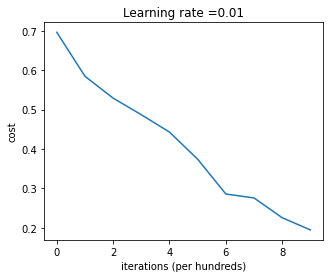

Accuracy: 0.9952153110047847
Accuracy: 0.62
lambda:  1.4  learning rate:  0.015  - 
Cost after iteration 0: 0.696145
Cost after iteration 100: 0.574358
Cost after iteration 200: 0.496071
Cost after iteration 300: 0.435358
Cost after iteration 400: 0.394236
Cost after iteration 500: 0.322353
Cost after iteration 600: 0.285237
Cost after iteration 700: 0.255540
Cost after iteration 800: 0.266160
Cost after iteration 900: 0.152987


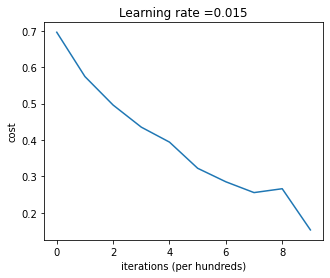

Accuracy: 0.9904306220095693
Accuracy: 0.74
lambda:  1.4  learning rate:  0.02  - 
Cost after iteration 0: 0.696145
Cost after iteration 100: 0.570008
Cost after iteration 200: 0.485291
Cost after iteration 300: 0.415086
Cost after iteration 400: 0.328813
Cost after iteration 500: 0.477777
Cost after iteration 600: 0.287203
Cost after iteration 700: 0.582499
Cost after iteration 800: 0.542939
Cost after iteration 900: 0.147262


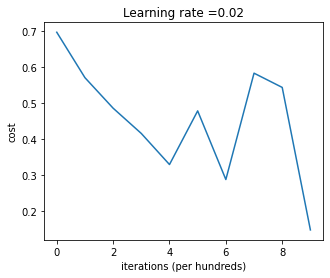

Accuracy: 0.7607655502392344
Accuracy: 0.6
lambda:  1.6  learning rate:  0.005  - 
Cost after iteration 0: 0.696517
Cost after iteration 100: 0.619231
Cost after iteration 200: 0.578788
Cost after iteration 300: 0.538646
Cost after iteration 400: 0.500474
Cost after iteration 500: 0.466321
Cost after iteration 600: 0.435636
Cost after iteration 700: 0.413257
Cost after iteration 800: 0.385428
Cost after iteration 900: 0.342351


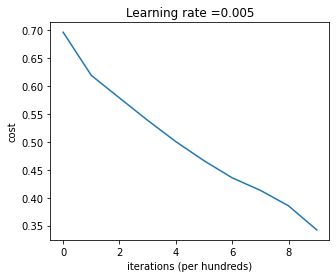

Accuracy: 0.9760765550239234
Accuracy: 0.72
lambda:  1.6  learning rate:  0.01  - 
Cost after iteration 0: 0.696517
Cost after iteration 100: 0.586654
Cost after iteration 200: 0.532725
Cost after iteration 300: 0.481125
Cost after iteration 400: 0.420716
Cost after iteration 500: 0.373143
Cost after iteration 600: 0.298318
Cost after iteration 700: 0.254794
Cost after iteration 800: 0.220598
Cost after iteration 900: 0.270482


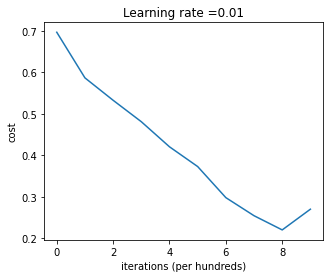

Accuracy: 0.9904306220095693
Accuracy: 0.62
lambda:  1.6  learning rate:  0.015  - 
Cost after iteration 0: 0.696517
Cost after iteration 100: 0.575650
Cost after iteration 200: 0.526163
Cost after iteration 300: 0.430251
Cost after iteration 400: 0.360501
Cost after iteration 500: 0.333089
Cost after iteration 600: 0.247491
Cost after iteration 700: 0.212015
Cost after iteration 800: 0.393572
Cost after iteration 900: 0.152877


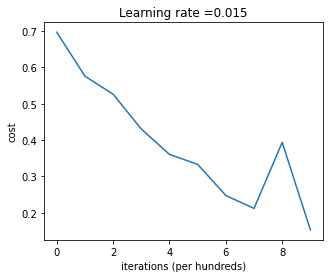

Accuracy: 0.9952153110047847
Accuracy: 0.68
lambda:  1.6  learning rate:  0.02  - 
Cost after iteration 0: 0.696517
Cost after iteration 100: 0.572245
Cost after iteration 200: 0.525606
Cost after iteration 300: 0.507728
Cost after iteration 400: 0.384564
Cost after iteration 500: 0.362221
Cost after iteration 600: 0.360872
Cost after iteration 700: 0.634355
Cost after iteration 800: 0.613628
Cost after iteration 900: 0.408605


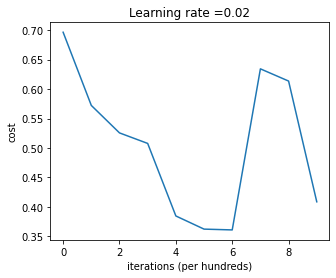

Accuracy: 0.4784688995215311
Accuracy: 0.72
lambda:  1.8  learning rate:  0.005  - 
Cost after iteration 0: 0.696890
Cost after iteration 100: 0.619722
Cost after iteration 200: 0.579413
Cost after iteration 300: 0.539420
Cost after iteration 400: 0.501291
Cost after iteration 500: 0.468107
Cost after iteration 600: 0.431370
Cost after iteration 700: 0.411910
Cost after iteration 800: 0.372522
Cost after iteration 900: 0.341123


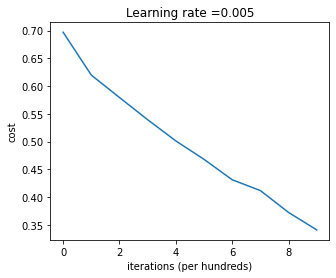

Accuracy: 0.9712918660287081
Accuracy: 0.78
lambda:  1.8  learning rate:  0.01  - 
Cost after iteration 0: 0.696890
Cost after iteration 100: 0.586305
Cost after iteration 200: 0.536648
Cost after iteration 300: 0.486831
Cost after iteration 400: 0.432214
Cost after iteration 500: 0.377374
Cost after iteration 600: 0.307521
Cost after iteration 700: 0.262109
Cost after iteration 800: 0.218161
Cost after iteration 900: 0.185512


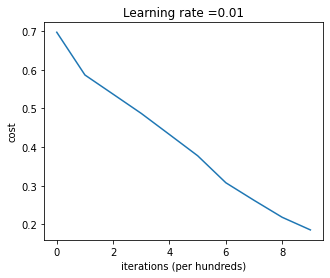

Accuracy: 0.9808612440191388
Accuracy: 0.82
lambda:  1.8  learning rate:  0.015  - 
Cost after iteration 0: 0.696890
Cost after iteration 100: 0.574998
Cost after iteration 200: 0.500743
Cost after iteration 300: 0.423213
Cost after iteration 400: 0.387397
Cost after iteration 500: 0.298148
Cost after iteration 600: 0.259285
Cost after iteration 700: 0.218377
Cost after iteration 800: 0.176408
Cost after iteration 900: 0.182631


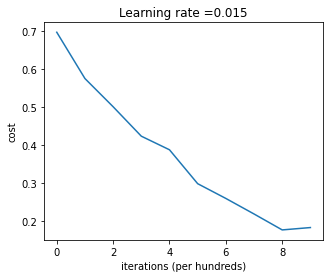

Accuracy: 0.9952153110047847
Accuracy: 0.68
lambda:  1.8  learning rate:  0.02  - 
Cost after iteration 0: 0.696890
Cost after iteration 100: 0.569772
Cost after iteration 200: 0.500389
Cost after iteration 300: 0.399057
Cost after iteration 400: 0.486112
Cost after iteration 500: 0.350795
Cost after iteration 600: 0.276845
Cost after iteration 700: 0.327805
Cost after iteration 800: 0.330940
Cost after iteration 900: 0.439164


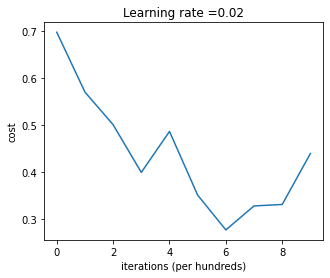

Accuracy: 0.9760765550239234
Accuracy: 0.74


In [ ]:
for i in range(1,5):
    lambd = 1 + 0.2*i
    for j in range(1,5):
        learning_rate = 0.005*j 
        print("lambda: ",1 + 0.2*i," learning rate: ",0.005*j," - ")
        parameters = L_layer_model(train_x, train_y, layers_dims,learning_rate,lambd, num_iterations = 1000, print_cost = True)
        pred_train = predict(train_x, train_y, parameters)
        pred_test = predict(test_x, test_y, parameters)